In [1]:
### imports

# external modules
import os
import gc
from os.path import exists
import os.path
import pandas as pd
import json
import sys
from sys import getsizeof
import itertools
import numpy as np
import matplotlib.pyplot as plt
import importlib
import time
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow import keras
from keras import backend as K
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.layers import Input, Dense, Concatenate
from tensorflow.keras.models import Model, Sequential, load_model
import importlib
import ast
import string

# local modules
sys.path.append('../utils')
import csv_utils as csvu
import json_utils as jsonu
import dataframe_utils as dfu
import hist_utils as hu
import autoencoder_utils as aeu
import plot_utils as pu
import generate_data_utils as gdu
import refruns_utils as rru
importlib.reload(csvu)
importlib.reload(jsonu)
importlib.reload(dfu)
importlib.reload(hu)
importlib.reload(aeu)
importlib.reload(pu)
importlib.reload(gdu)
importlib.reload(rru)
sys.path.append('../src')
sys.path.append('../src/classifiers')
sys.path.append('../src/cloudfitters')
import HistStruct
importlib.reload(HistStruct)
import FlexiStruct
importlib.reload(FlexiStruct)
import DataLoader
importlib.reload(DataLoader)
import AutoEncoder
importlib.reload(AutoEncoder)
import SeminormalFitter
import GaussianKdeFitter
import HyperRectangleFitter
importlib.reload(SeminormalFitter)
importlib.reload(GaussianKdeFitter)
importlib.reload(HyperRectangleFitter)

2022-07-27 16:05:36.020255: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /cvmfs/sft.cern.ch/lcg/releases/MCGenerators/thepeg/2.2.3-88592/x86_64-centos7-gcc11-opt/lib/ThePEG:/cvmfs/sft.cern.ch/lcg/releases/MCGenerators/herwig++/7.2.3-35f7a/x86_64-centos7-gcc11-opt/lib/Herwig:/cvmfs/sft.cern.ch/lcg/views/LCG_102swan/x86_64-centos7-gcc11-opt/lib/python3.9/site-packages/jaxlib/mlir/_mlir_libs:/cvmfs/sft.cern.ch/lcg/views/LCG_102swan/x86_64-centos7-gcc11-opt/lib/python3.9/site-packages/torch/lib:/cvmfs/sft.cern.ch/lcg/views/LCG_102swan/x86_64-centos7-gcc11-opt/lib/python3.9/site-packages/onnxruntime/capi/:/cvmfs/sft.cern.ch/lcg/views/LCG_102swan/x86_64-centos7-gcc11-opt/lib/python3.9/site-packages/tensorflow:/cvmfs/sft.cern.ch/lcg/views/LCG_102swan/x86_64-centos7-gcc11-opt/lib/python3.9/site-packages/tensorflow/contrib

<module 'HyperRectangleFitter' from '/eos/home-i01/k/khowey/SWAN_projects/ML4DQMDC-PixelAE/KH-AutoencoderTest/../src/cloudfitters/HyperRectangleFitter.py'>

In [2]:
### Controls

datadir = ''
filename = 'Top50.csv'

In [3]:
### Read in data

df = pd.read_csv(datadir + filename)
print('Discovered {} data points'.format(len(df)))
print(df)

# X Values
histcounts = np.zeros(len(df))
for i,histstring in enumerate(df.iloc[:]['Histlist']):
    counter = 0
    histlist = ast.literal_eval(histstring)
    for histgroup in histlist:
        for hist in histgroup:
            counter += 1
    histcounts[i] = counter        

jobData = df.iloc[:]['Job'].values

# Histogram types for bar chart
histTypes = []
histstring = df.iloc[len(df) - 1]['Histlist']
histlist = ast.literal_eval(histstring)
for histgroup in histlist:
    for hist in histgroup:
        histTypes.append(hist)

# Coloration
colorRank = np.array(['Worst Models'] * len(df))
colorDict = {'Best Model': 'blue', 'Top 10': 'green', 'Top 50': 'yellow', 'Worst Models': 'black'}
zDict = {'Best Model': 4, 'Top 10': 3, 'Top 50': 2, 'Worst Models': 1}
# Color the top 50 differently for distinction
for i in range(50):
    if i >= len(df): # Case df is not 50 long
        break
    if i == 0: 
        colorRank[i] = 'Best Model'
    elif i < 10:
        colorRank[i] = 'Top 10'
    else:
        colorRank[i] = 'Top 50'

Discovered 256 data points
     Unnamed: 0                                           Histlist  Job  \
0             0  [['chargeInner_PXLayer_1', 'chargeInner_PXLaye...  172   
1             1  [['chargeInner_PXLayer_1', 'chargeInner_PXLaye...  171   
2             2  [['chargeInner_PXLayer_1', 'chargeInner_PXLaye...  169   
3             3  [['chargeInner_PXLayer_1', 'chargeInner_PXLaye...  168   
4             4  [['chargeInner_PXLayer_1', 'chargeInner_PXLaye...  167   
..          ...                                                ...  ...   
251         251  [['chargeInner_PXLayer_1', 'chargeInner_PXLaye...   85   
252         252  [['chargeInner_PXLayer_1', 'chargeInner_PXLaye...   84   
253         253  [['chargeInner_PXLayer_1', 'chargeInner_PXLaye...   83   
254         254  [['chargeInner_PXLayer_1', 'chargeInner_PXLaye...   82   
255         255  [['chargeInner_PXLayer_1', 'chargeInner_PXLaye...   81   

     Train Time  Separable Percent Good  Worst Case Separation  F_measur

In [4]:
### Resort Data
df = df.sort_values(['Separability'], axis=0, ascending=False)

# X Values
histcounts = np.zeros(len(df))
for i,histstring in enumerate(df.iloc[:]['Histlist']):
    counter = 0
    histlist = ast.literal_eval(histstring)
    for histgroup in histlist:
        for hist in histgroup:
            counter += 1
    histcounts[i] = counter        

jobData = df.iloc[:]['Job'].values

# Histogram types for bar chart
histTypes = []
histstring = df.iloc[len(df) - 1]['Histlist']
histlist = ast.literal_eval(histstring)
for histgroup in histlist:
    for hist in histgroup:
        histTypes.append(hist)

# Coloration
colorRank = np.array(['Worst Models'] * len(df))
colorDict = {'Best Model': 'blue', 'Top 10': 'green', 'Top 50': 'yellow', 'Worst Models': 'black'}
zDict = {'Best Model': 4, 'Top 10': 3, 'Top 50': 2, 'Worst Models': 1}
# Color the top 50 differently for distinction
for i in range(50):
    if i >= len(df): # Case df is not 50 long
        break
    if i == 0: 
        colorRank[i] = 'Best Model'
    elif i < 10:
        colorRank[i] = 'Top 10'
    else:
        colorRank[i] = 'Top 50'

print(df)

     Unnamed: 0                                           Histlist  Job  \
145         145  [['chargeInner_PXLayer_1', 'chargeInner_PXLaye...   63   
27           27  [['chargeInner_PXLayer_1', 'chargeInner_PXLaye...   55   
50           50  [['chargeInner_PXLayer_1', 'chargeInner_PXLaye...   24   
155         155  [['chargeInner_PXLayer_1', 'chargeInner_PXLaye...   29   
29           29  [['chargeInner_PXLayer_1', 'chargeInner_PXLaye...   53   
..          ...                                                ...  ...   
251         251  [['chargeInner_PXLayer_1', 'chargeInner_PXLaye...   85   
252         252  [['chargeInner_PXLayer_1', 'chargeInner_PXLaye...   84   
253         253  [['chargeInner_PXLayer_1', 'chargeInner_PXLaye...   83   
254         254  [['chargeInner_PXLayer_1', 'chargeInner_PXLaye...   82   
255         255  [['chargeInner_PXLayer_1', 'chargeInner_PXLaye...   81   

     Train Time  Separable Percent Good  Worst Case Separation  F_measure  \
145  406.909626       

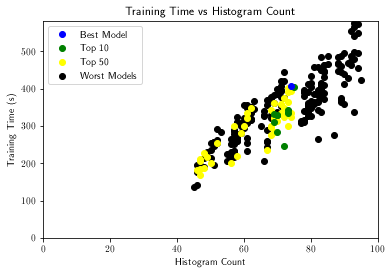

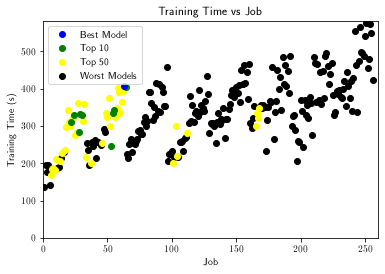

In [5]:
### Plotting time data

timeData = df.iloc[:]['Train Time'].values

# Shows speed vs complexity
fig, ax = plt.subplots()
for g in np.unique(colorRank):
    ix = np.where(colorRank == g)
    ax.scatter(histcounts[ix], timeData[ix], c = colorDict[g], label = g, zorder = zDict[g])
ax.legend()
plt.title('Training Time vs Histogram Count')
plt.xlim([0, 100])
plt.ylim([0, max(timeData) + 5])
plt.xlabel('Histogram Count')
plt.ylabel('Training Time (s)')
plt.show()


# Shows speed vs histogram type
fig, ax = plt.subplots()
for g in np.unique(colorRank):
    ix = np.where(colorRank == g)
    ax.scatter(jobData[ix], timeData[ix], c = colorDict[g], label = g, zorder = zDict[g])
ax.legend()
plt.title('Training Time vs Job')
plt.xlim([0, len(df) + 4])
plt.ylim([0, max(timeData) + 5])
plt.xlabel('Job')
plt.ylabel('Training Time (s)')
plt.show()

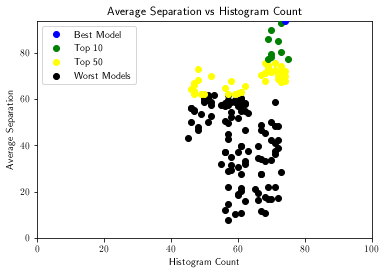

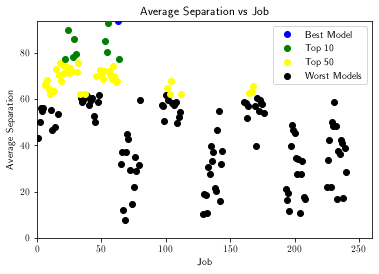

In [6]:
### Plotting performance metrics

## Average Separation
avSeparation = df.iloc[:]['Separability'].values


# Provide data on performance vs complexity
fig, ax = plt.subplots()
for g in np.unique(colorRank):
    ix = np.where(colorRank == g)
    ax.scatter(histcounts[ix], avSeparation[ix], c = colorDict[g], label = g, zorder = zDict[g])
ax.legend()
plt.title('Average Separation vs Histogram Count')
plt.xlim([0, 100])
plt.ylim([0, max(avSeparation)])
plt.xlabel('Histogram Count')
plt.ylabel('Average Separation')
plt.show()

# Provide data on performance vs histogram type
fig, ax = plt.subplots()
for g in np.unique(colorRank):
    ix = np.where(colorRank == g)
    ax.scatter(jobData[ix], avSeparation[ix], c = colorDict[g], label = g, zorder = zDict[g])
ax.legend()
plt.title('Average Separation vs Job')
plt.xlim([0, len(df) + 4])
plt.ylim([0, max(avSeparation)])
plt.xlabel('Job')
plt.ylabel('Average Separation')
plt.show()

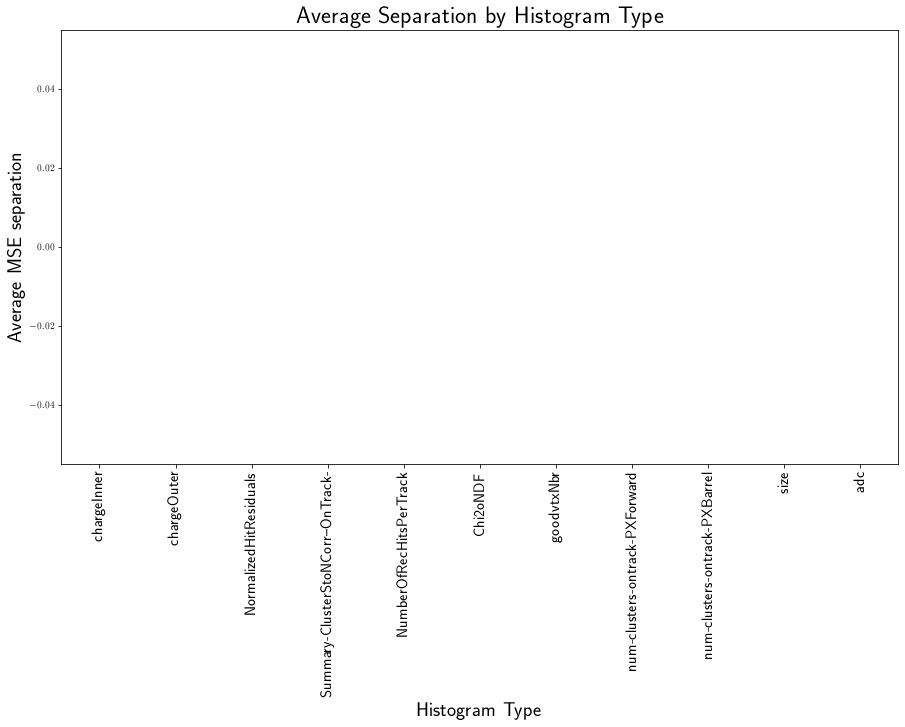

In [8]:
### Plotting data about most useful histograms

histNames = ['chargeInner', 'chargeOuter', 'adc', 'size',
            'NormalizedHitResiduals', 
            'Summary_ClusterStoNCorr__OnTrack_',
            #'Summary_TotalNumberOfDigis_',
            #'NumberOfTracks', 
            'NumberOfRecHitsPerTrack', 
            'Chi2oNDF',
            'goodvtxNbr',
            #'NumberOfClustersInPixel', 
            'num_clusters_ontrack_PXBarrel', 
            'num_clusters_ontrack_PXForward', 
            #'NumberOfClustersInStrip'
]

# Get data about histograms types
histTypes = {}
for i,histstring in enumerate(df.iloc[:]['Histlist']):
    counter = 0
    histlist = ast.literal_eval(histstring)
    for histgroup in histlist:
        for hist in histgroup:
            if hist not in histTypes.keys():
                histTypes[hist] = []
            histTypes[hist].append(i)
            
# Distill dataset to the generic histogram names        
avgHistSep = []
labels = {}
knownHists = []
for i,hist in enumerate(histTypes.keys()):
    newHist = True
    for histname in knownHists:
        if histname in hist:
            newHist = False
    if newHist:
        for histname in histNames:
            if histname in hist:
                histSeps = avSeparation[histTypes[hist]]
                avgHistSep.append(np.mean(histSeps))
                labels[i] = histname
                knownHists.append(histname)
                break

# Make string compatible with matplotlib
for i,histname in enumerate(knownHists):
    newName = histname.replace('_','-')
    knownHists[i] = newName
    
avgHistSepPlot = pd.Series(avgHistSep)

plt.figure(figsize=(15, 8))
ax = avgHistSepPlot.plot(kind="bar")
ax.set_title("Average Separation by Histogram Type",fontsize=24)
ax.set_xlabel("Histogram Type", fontsize=20)
ax.set_ylabel("Average MSE separation", fontsize=20)
ax.set_xticklabels(knownHists, fontsize=15)

plt.show()

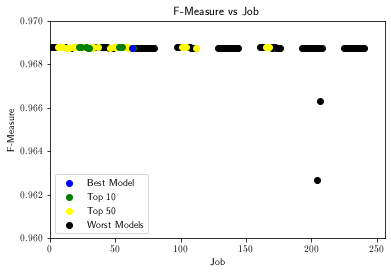

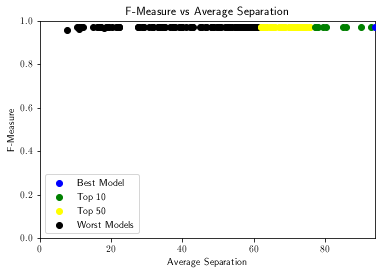

In [19]:
### F-Measure Calculation
fm = df.iloc[:]['F_measure'].values

fig, ax = plt.subplots()
for g in np.unique(colorRank):
    ix = np.where(colorRank == g)
    ax.scatter(jobData[ix], fm[ix], c = colorDict[g], label = g, zorder = zDict[g])
ax.legend()
plt.title('F-Measure vs Job')
plt.xlim([0, len(df)])
plt.ylim([0.96, 0.97])
plt.xlabel('Job')
plt.ylabel('F-Measure')
plt.show()

fig, ax = plt.subplots()
for g in np.unique(colorRank):
    ix = np.where(colorRank == g)
    ax.scatter(avSeparation[ix], fm[ix], c = colorDict[g], label = g, zorder = zDict[g])
ax.legend()
plt.title('F-Measure vs Average Separation')
plt.xlim([0, max(avSeparation)])
plt.ylim([0, 1])
plt.xlabel('Average Separation')
plt.ylabel('F-Measure')
plt.show()

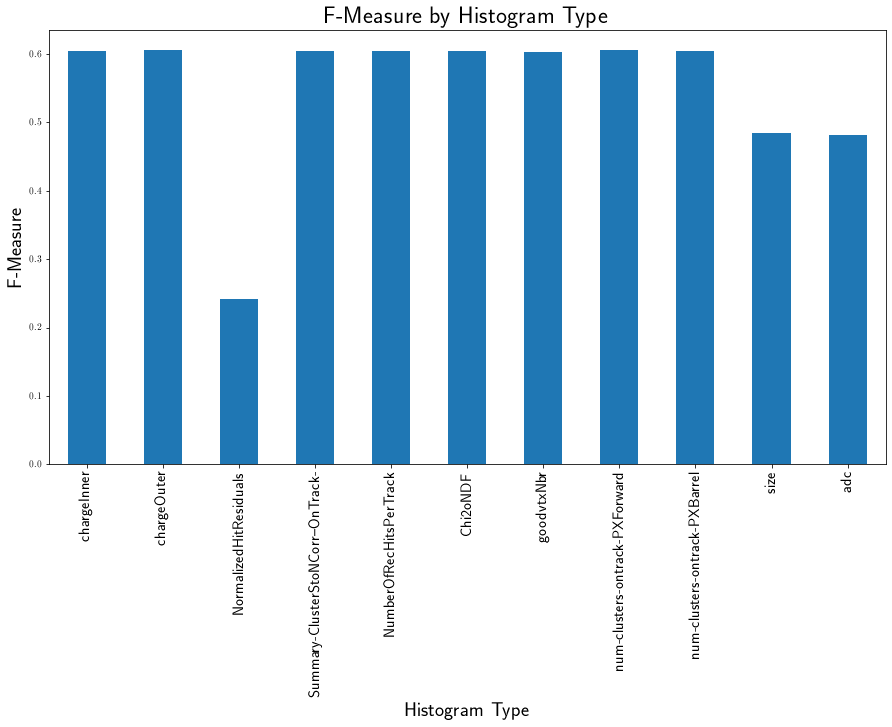

In [16]:
### Sep Percents

## Bad
# Distill dataset to the generic histogram names        
avgHistSep = []
labels = {}
knownHists = []
for i,hist in enumerate(histTypes.keys()):
    newHist = True
    for histname in knownHists:
        if histname in hist:
            newHist = False
    if newHist:
        for histname in histNames:
            if histname in hist:
                histSeps = []
                for element in fm[histTypes[hist]]:
                    if np.isnan(element): histSeps.append(0)
                    else: histSeps.append(element)
                avgHistSep.append(np.mean(histSeps))
                labels[i] = histname
                knownHists.append(histname)
                break

# Make string compatible with matplotlib
for i,histname in enumerate(knownHists):
    newName = histname.replace('_','-')
    knownHists[i] = newName
    
avgHistSepPlot = pd.Series(avgHistSep)

plt.figure(figsize=(15, 8))
ax = avgHistSepPlot.plot(kind="bar")
ax.set_title("F-Measure by Histogram Type",fontsize=24)
ax.set_xlabel("Histogram Type", fontsize=20)
ax.set_ylabel("F-Measure", fontsize=20)
ax.set_xticklabels(knownHists, fontsize=15)

plt.show()

In [ ]:
### Memory Consumption

filesizes = np.zeros(len(df))
for i in range(len(filesizes)):
    output_stream = os.popen('du -sh ../SavedModels/Permutations/Job{}'.format(i + 1))
    out = output_stream.read()
    out = out.split()
    size = out[0].strip(string.ascii_letters)
    magnitude = out[0].strip(string.digits)
    
    if magnitude == 'K':
        size = size/1000
    elif magnitude == 'M':
        size = size
    elif magnitude == 'G':
        size = size*1000
    else:
        raise Exception('Unsupported File Size')
    filesizes[i] = size

# Provide data on performance vs complexity
fig, ax = plt.subplots()
for g in np.unique(colorRank):
    ix = np.where(colorRank == g)
    ax.scatter(histcounts[ix], filesizes[ix], c = colorDict[g], label = g, zorder = zDict[g])
ax.legend(loc = "upper left")
plt.title('Model Size vs Histogram Count')
plt.xlim([0, 100])
plt.ylim([0, max(filesizes) + 5])
plt.xlabel('Histogram Count')
plt.ylabel('Model Size (MB)')
plt.show()